In [1]:
# Imports 
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import sys, os
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.svm import SVC

In [2]:
def pad_wav(wav, wav_max_length, pad=0):
  """Pads audio wave sequence to be `wav_max_length` long."""
  dim = wav.shape[1]
  padded = np.zeros((wav_max_length, dim)) + pad
  if len(wav) > wav_max_length:
    wav = wav[:wav_max_length]
  length = len(wav)
  padded[:length, :] = wav
  return padded, length

In [6]:
#Features we want right now: min f0, max f0, and mean f0 and maybe rms (not sure exactly what that is but was used in the paper)
#path = '/home/CREMA-D/AudioWAV/'
path = '/Users/gabesaldivar/Desktop/cs224s/CREMA-D/AudioWAV/'
files = os.listdir(path)

#summary = pd.read_csv('/home/CREMA-D/processedResults/summaryTable.csv')
summary = pd.read_csv('/Users/gabesaldivar/Desktop/cs224s/CREMA-D/processedResults/summaryTable.csv')

num_files = len(os.listdir(path)) #not sure how you want to count files
count = 0

# 6 or 8
num_features = 8

# Keep track of min and max duration of all data
min_dur = np.inf
max_dur = 0

X = np.zeros((num_files, (250 * 128) + num_features))# or +8 for features
Y = np.zeros(num_files).astype(str)
for sample in tqdm(files): #depends on how you access
    file = os.path.join(path,sample)
    current_wav, current_sr = librosa.load(file) #fix for set up 
    f0_series = librosa.yin(current_wav, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
    rms_series = librosa.feature.rms(y=current_wav)
    f0_max = np.amax(f0_series)
    f0_min = np.amin(f0_series)
    # Get f0 range
    f0_range = f0_max - f0_min
    # duration
    duration = librosa.get_duration(y=current_wav, sr=current_sr)
    
    # Outer duration
    if duration > max_dur:
        max_dur = duration
    if duration < min_dur:
        min_dur = duration
        
    # Get the pitches
#     pitches, magnitudes = librosa.piptrack(y=current_wav, sr=current_sr)
#     pitch_max = np.amax(pitches)
#     pitch_min = np.amin(pitches)
#     # Get f0 range
#     pitch_range = pitch_max - pitch_min
#     pitch_mean = np.mean(pitches)
    
    f0_mean = np.mean(f0_series)
    rms_max = np.amax(rms_series)
    rms_min = np.amin(rms_series)
    rms_mean = np.mean(rms_series)
#     x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean, pitch_max, pitch_min, 
#                   pitch_range, pitch_mean])
    mel_spec = librosa.feature.melspectrogram(current_wav, current_sr)
    m_log = librosa.power_to_db(mel_spec)
    m_log_norm = librosa.util.normalize(m_log)
    padded_wav, input_length = pad_wav(m_log_norm.T, 250)
    flat_mel = padded_wav.flatten()
    
#    x = np.array([f0_min, f0_max, f0_mean, rms_min, rms_max, rms_mean]) # for 6 features
    x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean]) # for 8 features

    x = np.append(x, flat_mel)

    X[count,:] = x
    # Get the label for VoiceVote
    info = summary.loc[summary['FileName'] == sample.split('.')[0]]
    try:
        Y[count] = info['VoiceVote'].values[0]
    except Exception as ex:
        print(f'info: {info}')
        print(f'index count: {count}')
        index = count
        print(f'unable to find file: {sample}')
        count -= 1
    count += 1
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')

 80%|████████  | 5956/7442 [08:02<01:53, 13.06it/s]

info: Empty DataFrame
Columns: [Unnamed: 0, FileName, VoiceVote, VoiceLevel, FaceVote, FaceLevel, MultiModalVote, MultiModalLevel]
Index: []
index count: 5952
unable to find file: 1040_ITH_SAD_X.wav


100%|██████████| 7442/7442 [10:03<00:00, 12.87it/s]

shape of train data: (7442, 32008)
shape of labels: (7442,)


In [7]:
# Get data and labels for training
train_split = int(0.8 * num_files)
print('train_split: ', train_split)
print(f'train size: {X[:train_split].shape}, val size: {X[train_split:].shape}')

model =  SVC()
model.fit(X[:train_split], Y[:train_split])
predictions = model.predict(X[train_split:])
score = model.score(X[train_split:],Y[train_split:])
print(f'Test accuracy score: {score}')

f1 = f1_score(Y[train_split:], predictions, average='macro')
print(f'macro f1 score: {f1}')
f1 = f1_score(Y[train_split:], predictions, average='micro')
print(f'micro f1 score: {f1}')

'''model2 =  SVC(kernel="linear")
model2.fit(X[:train_split], Y[:train_split])
predictions = model2.predict(X[train_split:])
score = model2.score(X[train_split:],Y[train_split:])
print(f'Test accuracy score, model2: {score}')

f1 = f1_score(Y[train_split:], predictions, average='macro')
print(f'macro f1 score, model2: {f1}')
f1 = f1_score(Y[train_split:], predictions, average='micro')
print(f'micro f1 score, model2: {f1}')'''



train_split:  5953
train size: (5953, 32008), val size: (1489, 32008)
Test accuracy score: 0.5345869711215581
macro f1 score: 0.027406487969916935
micro f1 score: 0.5345869711215581


'model2 =  SVC(kernel="linear")\nmodel2.fit(X[:train_split], Y[:train_split])\npredictions = model2.predict(X[train_split:])\nscore = model2.score(X[train_split:],Y[train_split:])\nprint(f\'Test accuracy score, model2: {score}\')\n\nf1 = f1_score(Y[train_split:], predictions, average=\'macro\')\nprint(f\'macro f1 score, model2: {f1}\')\nf1 = f1_score(Y[train_split:], predictions, average=\'micro\')\nprint(f\'micro f1 score, model2: {f1}\')'

ValueError: The number of FixedLocator locations (32), usually from a call to set_ticks, does not match the number of ticklabels (38).

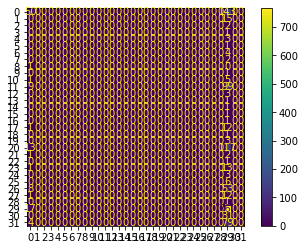

In [5]:
# Confusion matrix plot
sklearn.metrics.plot_confusion_matrix(model, X[train_split:],Y[train_split:], )  
plt.show() 

In [ ]:
# Some basic stats for the dataset
avg = np.mean(X, axis=0)
stats = ['f0_min', 'f0_max', 'f0_mean', 'rms_min', 'rms_max', 'rms_mean']
for j,stat in enumerate(stats):
    print(f'{stat} average: {avg[j]}')